<a href="https://colab.research.google.com/github/jax-ml/bonsai/blob/main/bonsai/models/efficientnet/tests/EfficientNet_ImageNet_validation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ImageNet Classification with EfficientNet-B0**

This notebook demonstrates how to use the EfficientNet-B0 model from the Bonsai library to perform ImageNet classification. Note that this notebook loads a **trained** model. It serves to validate the model's architecture and demonstrate the full inference pipeline.

*This colab demonstrates the EfficientNet implementation from the [Bonsai library](https://github.com/jax-ml/bonsai).*

## **1. Set-up**

In [ ]:
!pip install -q git+https://github.com/jax-ml/bonsai@main
!pip install -q pillow matplotlib requests
!pip install -q torch timm
!pip install -q ipywidgets

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image

print(f"JAX version: {jax.__version__}")
print(f"JAX device: {jax.devices()[0].platform}")

## **2. Load Utilities**

Download an image, load ImageNet class names, and preprocess the image according to EfficientNet's requirements.

In [2]:
def load_imagenet_classes():
    """Load ImageNet class names from a common source."""
    url = "https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
    response = requests.get(url)
    response.raise_for_status()
    classes = response.text.strip().split("\n")
    return classes


def preprocess_image(image_url, target_size=(224, 224)):
    """Download and preprocess an image for EfficientNet inference."""

    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"}

    response = requests.get(image_url, stream=True, headers=headers)
    response.raise_for_status()
    image = Image.open(response.raw).convert("RGB")

    # Resize to slightly larger, then center crop (more standard approach)
    resize_size = int(target_size[0] / 0.875)  # ~256 for 224
    image = image.resize((resize_size, resize_size), Image.Resampling.BICUBIC)

    # Center crop
    left = (resize_size - target_size[0]) // 2
    top = (resize_size - target_size[1]) // 2
    image = image.crop((left, top, left + target_size[0], top + target_size[1]))

    # Convert to array and normalize
    image_array = np.array(image).astype(np.float32) / 255.0

    # ImageNet normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_array = (image_array - mean) / std

    return jnp.array(image_array[None, ...]), image


imagenet_classes = load_imagenet_classes()

## **3. Load EfficientNet Model and Run Inference**

Now let's load the EfficientNet-B0 model from the Bonsai library. We will initialize it with random weights.

In [ ]:
# Import model creation and weight loading functions
from bonsai.models.efficientnet import modeling
from bonsai.models.efficientnet import params as params_lib

# 1. Define model name
jax_model = params_lib.create_efficientnet_from_pretrained(0)

# Prepare the input image
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Giant_Panda_2004-03-2.jpg/1024px-Giant_Panda_2004-03-2.jpg"
# 3. Use the correct resolution for B0
input_tensor, original_image = preprocess_image(image_url, target_size=(224, 224))

# Run inference with your JAX model
jax_logits = jax_model(input_tensor, training=False)

# Post-process the output using JAX functions
jax_probs = jax.nn.softmax(jax_logits, axis=-1)

# Get top-5 predictions
top_k = 5
top_probs, top_indices = jax.lax.top_k(jax_probs[0], k=top_k)

# Ensure the results are on the host for printing
top_probs = np.array(top_probs)
top_indices = np.array(top_indices)

# Print the results
print(f"Input image shape: {input_tensor.shape}")
print(f"Output logits shape: {jax_logits.shape}")
print("\n--- Top 5 Predictions (from BONSAI JAX model B0) ---")
for i, (idx, prob) in enumerate(zip(top_indices, top_probs)):
    print(f"{i + 1}. {imagenet_classes[idx]}: {prob:.4f}")

## **4. Visualize Results**

Let's visualize the input image and the top-5 (random) predictions from our untrained model.

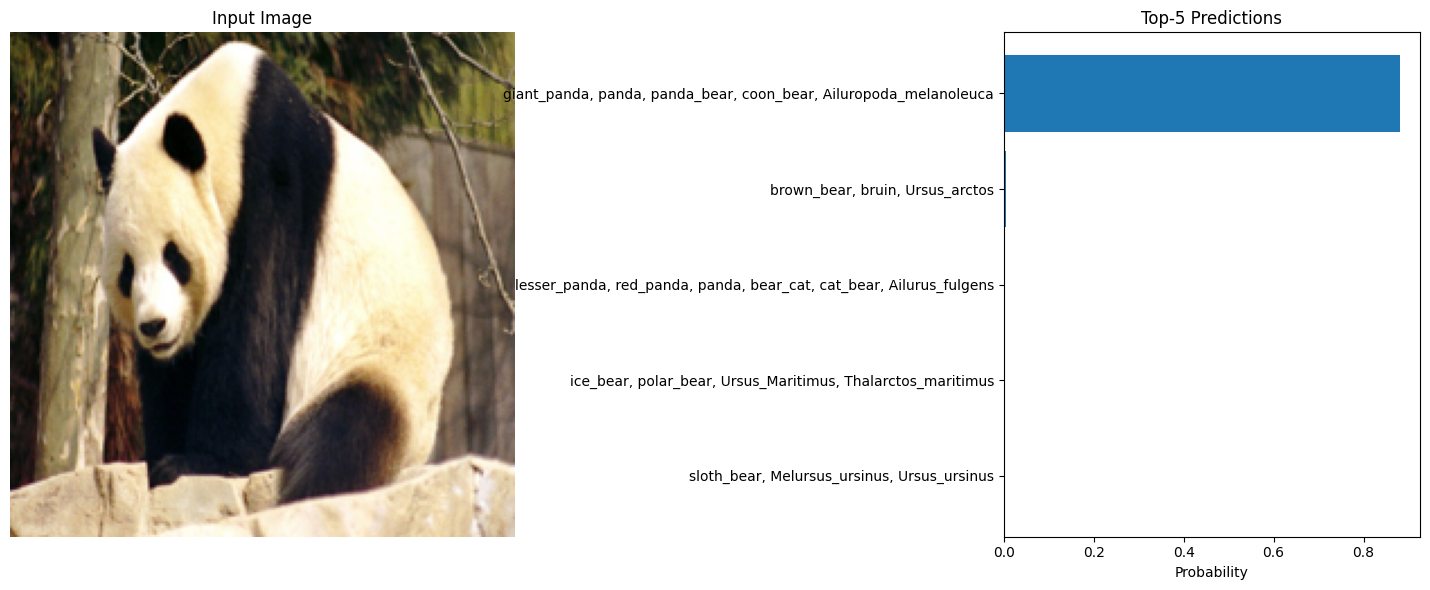

In [4]:
def show_image_with_predictions(image, predictions):
    """Display image with top-k predictions."""
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"width_ratios": [3, 2]})

    # Show image
    ax1.imshow(image)
    ax1.set_title("Input Image")
    ax1.axis("off")

    # Show predictions
    class_names = [p[0] for p in predictions]
    scores = [p[1] for p in predictions]
    y_pos = np.arange(len(class_names))

    ax2.barh(y_pos, scores, align="center")
    ax2.set_yticks(y_pos, labels=class_names)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_xlabel("Probability")
    ax2.set_title("Top-5 Predictions")

    plt.tight_layout()
    plt.show()


predictions = [(imagenet_classes[i], p) for i, p in zip(top_indices, top_probs)]
show_image_with_predictions(original_image, predictions)

## **Conclusion**

This notebook demonstrates how to set up and run the Bonsai EfficientNet-B0 model. You can successfully:

1. **Instantiate the EfficientNet model** with the B0 configuration.
2. **Preprocess a real image** from the web.
3. **Perform a forward pass** to get classification logits.
4. **Visualize the output**, confirming the model's end-to-end pipeline is functional.